# Tuning SGD Optimizer for Model Performance

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import load_model
#https://github.com/jrosebr1/imutils
from imutils import paths
import imutils
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import pickle
from tensorflow import reset_default_graph

In [3]:
class AlexNet:
    #optimizer to use should be 'sgd'
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        #input shape is 227x227x3
        inputShape = (height, width, depth)
        model.add(Conv2D(filters=96, kernel_size=11, strides=4,
                         input_shape=inputShape, activation='relu'))
        model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
        model.add(Conv2D(filters=256, kernel_size=5, strides=1,
                         padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
        model.add(Conv2D(filters=384, kernel_size=3, strides=1,
                         padding='same', activation='relu'))
        model.add(Conv2D(filters=256, kernel_size=3, strides=1,
                         padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
        model.add(Flatten())
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(classes, activation='softmax'))
        
        return model

In [4]:
def pre_process(width, height, path):
    """
    Resize and rescale images stored in image folder.
    
    Return pre-processed data and labels for the classes based
    on sub-directories in the image folder
    """
    #containers for pre-processed image data and class labels
    data = []
    labels = []

    #images directory contains 3 sub-directories: 'poison_ivy', 'poison_oak', 'poison_sumac'
    #randomly get image paths and shuffle them
    # current path 'C:\\Users\\jltsa\\Desktop\\Project_2\\images'
    image_paths = sorted(list(paths.list_images(path)))
    random.seed(42)
    random.shuffle(image_paths)

    #preprocess images to width x height pixels as required for LeNet
    for image_path in image_paths:
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, (width, height))
            image = img_to_array(image)
            data.append(image)
    
            #Extract class labels
            label = image_path.split(os.path.sep)[-2]
            if label == 'poison_ivy':
                label = 0
            elif label == 'poison_oak':
                label = 1
            else:
                label = 2
            labels.append(label)
       
    #Scal pixel intensities from 0 to 1
    data = np.array(data, dtype='float') / 255.0
    labels = np.array(labels)
    
    return data, labels

In [5]:
def plot_acc_loss(epochs, model, title=None, save=False, path=None, save_as=None):
    """
    plot the accuracy and loss of the train and test data
    save plot optional
    """
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0,epochs), model.history.history['loss'], label='Train_loss')
    plt.plot(np.arange(0,epochs), model.history.history['val_loss'], label='Val_loss')
    plt.plot(np.arange(0,epochs), model.history.history['acc'], label='Train_acc')
    plt.plot(np.arange(0,epochs), model.history.history['val_acc'], label='Val_acc')
    plt.title('Training Loss and Accuracy' + ' ' + str(title))
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Acc')
    plt.legend(loc='upper left')
    
    if save == True:
        plt.savefig(path+'\\' + str(save_as) + '.png')

In [49]:
def plot_metric(metric, y_label, title=None, save=False, path=None, save_as=None):
    """
    plot single metric
    save plot optional
    """
    plt.style.use('ggplot')
    plt.figure(figsize=(20, 10))
    for met in range(len(metric)):
        plt.plot(np.arange(0,len(metric[met])), metric[met], label=y_label+str(met))
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(y_label)
    plt.legend(loc='upper left')
    
    if save == True:
        plt.savefig(str(path)+'\\' + str(save_as) + '.png')
    

In [7]:
#To increase the amount of training data, build an image generator using data augmentation
aug_gen = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                            height_shift_range=0.1, shear_range=0.2,
                            zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

In [9]:
#Initialize global training variables

EPOCHS = 30
#Learning rate
#LR = 1e-3
#Batch Size
BS = 15
path_to_img = 'C:\\Users\\jltsa\\Desktop\\Project_2\\images'
path_to_models = 'models\\'

In [9]:
sgd1 = SGD(lr=0.01, momentum=0.5, nesterov=True)
sgd2 = SGD(lr=0.01, momentum=0.8, nesterov=True)
sgd3 = SGD(lr=0.001, momentum=0.5, nesterov=True)
sgd4 = SGD(lr=0.001, momentum=0.8, nesterov=True)
sgd5 = SGD(lr=0.0001, momentum=0.5, nesterov=True)
sgd6 = SGD(lr=0.0001, momentum=0.8, nesterov=True)
sgd7 = SGD(lr=0.0008, momentum=0.85, nesterov=True)

opts = [sgd1, sgd2, sgd3, sgd4, sgd5, sgd6]

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
loss = []
val_loss = []
acc = []
val_acc = []

In [11]:
def train_model(im_path, model_path, optimizer, weights):

    data, labels = pre_process(227, 227, im_path)
    #Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)
    #One hot encoding
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    

    #create a checkpoint to store the best weights of the model
    #to use these weights later, initialize the same model architecture that the weights were trained from
    #then call model.load_weights('best_weights_alex.h5')
    #can make predictions model.predict_classes(data)
    model_path = model_path+weights+".h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)
    #add early stopping if 
    earlystop = EarlyStopping(monitor='val_loss', patience=4)
        
    callbacks_list=[checkpoint, earlystop]
        
    #Initialize model
    model = AlexNet.build(width=227, height=227, depth=3, classes=3)
    #opt_alex = Adam(lr=LR, decay=LR / EPOCHS)

    #if model has 2 classes use loss='binary_crossentropy'
    #AlexNet performs better with 'sgd' optimizer
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    #fit model using a generator to increase variation and amount of data
    model.fit_generator(aug_gen.flow(X_train, y_train, batch_size=BS),
                    validation_data=(X_test, y_test), steps_per_epoch=len(X_train // BS),
                    epochs=EPOCHS, callbacks=callbacks_list, verbose=1)
    #save history for loss and val scores
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    acc.append(model.history.history['acc'])
    val_acc.append(model.history.history['val_acc'])

In [12]:
train_model(path_to_img, path_to_models, sgd7, "SGD7")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
543/543 [==============================] - 99s 183ms/step - loss: 0.9967 - acc: 0.4776 - val_loss: 1.0076 - val_acc: 0.4972
Epoch 2/30
543/543 [==============================] - 103s 189ms/step - loss: 0.9630 - acc: 0.5330 - val_loss: 0.9571 - val_acc: 0.5470
Epoch 3/30
543/543 [==============================] - 101s 186ms/step - loss: 0.9435 - acc: 0.5440 - val_loss: 0.9538 - val_acc: 0.5249ss: 0.9427 - acc: 0
Epoch 4/30
543/543 [==============================] - 99s 183ms/step - loss: 0.9310 - acc: 0.5449 - val_loss: 0.9227 - val_acc: 0.5359
Epoch 5/30
543/543 [==============================] - 95s 175ms/step - loss: 0.9155 - acc: 0.5554 - val_loss: 0.9116 - val_acc: 0.6022
Epoch 6/30
543/543 [==============================] - 94s 174ms/step - loss: 0.9005 - acc: 0.5720 - val_loss: 0.9097 - val_acc: 0.5359
Epoch 

In [43]:
i =[]
i.append(val_acc[6])

In [44]:
i

[[0.5138121709968504,
  0.508287306977899,
  0.5580110661891284,
  0.6022099635219047,
  0.5745856557761767,
  0.6298342737374385,
  0.5801105148555166,
  0.6132596866201959,
  0.46961327613387976]]

In [22]:
with open('metrics\\'+'val_acc.pickle', 'rb') as file:
    acc = pickle.load(file)

In [36]:
acc[6] = acc[6][0]

In [39]:
with open('metrics\\'+'val_acc.pickle', 'rb') as file:
    acc = pickle.load(file)

In [40]:
acc

[[0.4890309785313739,
  0.5339610954630847,
  0.5408663058853419,
  0.551836546161606,
  0.5658506132227328,
  0.5897049762491003,
  0.6364548250489237,
  0.6760828792936608,
  0.7261770395572577],
 [0.458693757011573,
  0.5166352956027859,
  0.5363465319245548,
  0.5381722609411285,
  0.5575643603916222,
  0.5797865833097932,
  0.60235679306541,
  0.6274953090426163,
  0.6641556981031953],
 [0.4576908750400009,
  0.502071577984061,
  0.5384808696988836,
  0.5384229818774418,
  0.5482737136033071,
  0.5495292065282775,
  0.5558480798284691,
  0.5578154590787636,
  0.5604519947381118,
  0.5634950653150056,
  0.5718769787395068,
  0.5740113165587355,
  0.5812962438074796,
  0.5866917942540121,
  0.5918393142142538,
  0.6008524685403197,
  0.6096673123299964,
  0.6190835083271824,
  0.630186804095665,
  0.6433145181158393,
  0.6419334764871221,
  0.6603986630654057],
 [0.4796289472359829,
  0.5299435181637941,
  0.5421217992200241,
  0.5530901508487763,
  0.5596986980368638,
  0.568236049

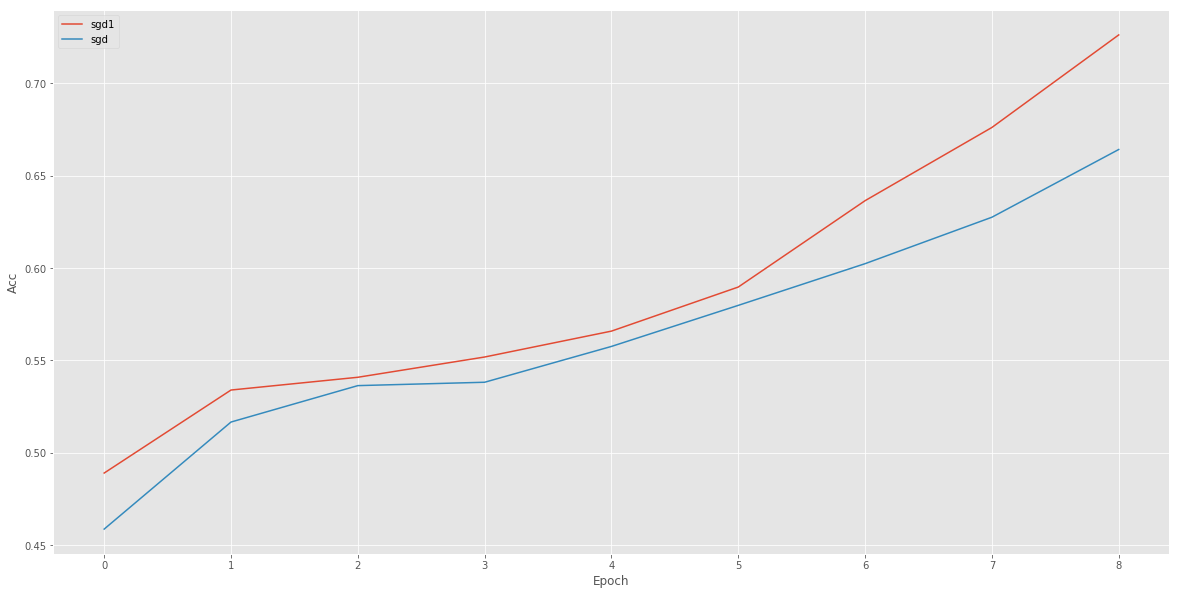

In [48]:

plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
plt.plot(np.arange(0,9), acc[0], label='sgd1')
plt.plot(np.arange(0,9), acc[1], label='sgd')
#plt.plot(np.arange(0,epochs), model.history.history['acc'], label='Train_acc')
#plt.plot(np.arange(0,epochs), model.history.history['val_acc'], label='Val_acc')
#plt.title('Training Loss and Accuracy' + ' ' + str(title))
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(loc='upper left')

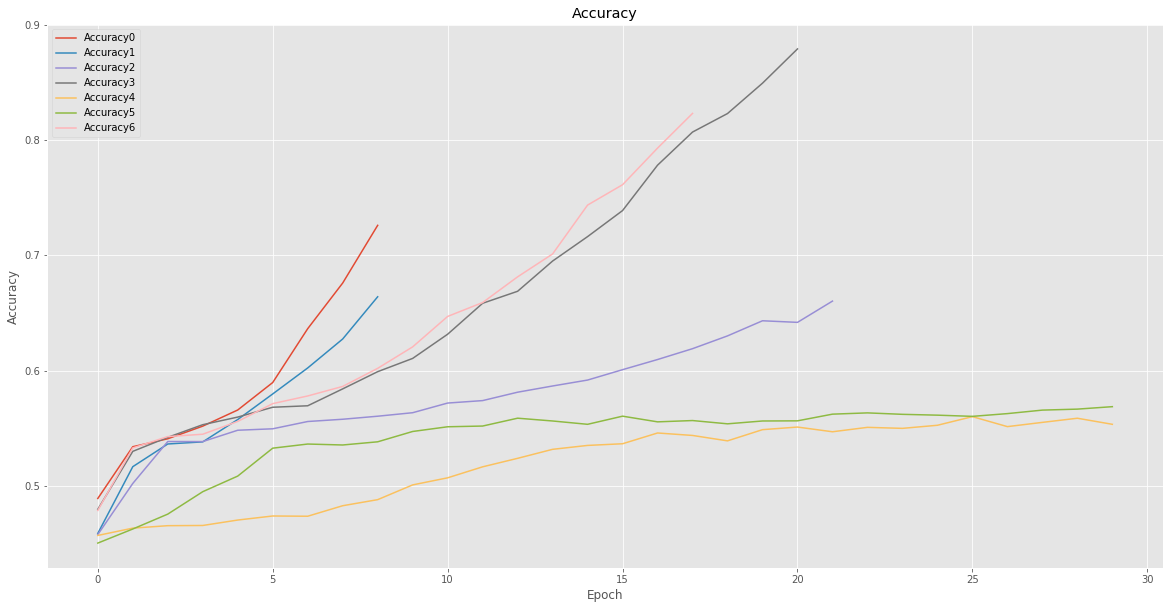

In [50]:
plot_metric(acc, "Accuracy", title="Accuracy", save=False, path=None, save_as=None)

In [34]:
e

[[0.5138121709968504,
  0.508287306977899,
  0.5580110661891284,
  0.6022099635219047,
  0.5745856557761767,
  0.6298342737374385,
  0.5801105148555166,
  0.6132596866201959,
  0.46961327613387976],
 [[0.48066299182275385,
   0.5414364812123841,
   0.563535927738274,
   0.5414364812123841,
   0.5524862067804811,
   0.6077348222719372,
   0.5690607864883065,
   0.6132596866201959,
   0.6740331682711016]],
 [[0.4751381278038025,
   0.5248618968942548,
   0.524861894424449,
   0.5524862071097885,
   0.5193370353451091,
   0.5303867584434003,
   0.5193370353451091,
   0.5690607917572253,
   0.5359116175227402,
   0.5359116175227402,
   0.5635359302080797,
   0.5138121725610607,
   0.5745856533063709,
   0.5966851044425648,
   0.5856353739348564,
   0.5801105148555166,
   0.6353591377563899,
   0.6298342737374385,
   0.5303867559735946,
   0.5635359302080797,
   0.6187845506391473,
   0.6574585790133608]],
 [[0.5193370328753034,
   0.519337032545996,
   0.5469613455606429,
   0.558011068658

In [38]:
with open('metrics\\'+'acc.pickle', 'wb') as file:
            pickle.dump(acc, file)

In [36]:
with open('metrics\\'+'val_acc.pickle', 'rb') as file:
    e = pickle.load(file)
e

[[0.5138121709968504,
  0.508287306977899,
  0.5580110661891284,
  0.6022099635219047,
  0.5745856557761767,
  0.6298342737374385,
  0.5801105148555166,
  0.6132596866201959,
  0.46961327613387976],
 [[0.48066299182275385,
   0.5414364812123841,
   0.563535927738274,
   0.5414364812123841,
   0.5524862067804811,
   0.6077348222719372,
   0.5690607864883065,
   0.6132596866201959,
   0.6740331682711016]],
 [[0.4751381278038025,
   0.5248618968942548,
   0.524861894424449,
   0.5524862071097885,
   0.5193370353451091,
   0.5303867584434003,
   0.5193370353451091,
   0.5690607917572253,
   0.5359116175227402,
   0.5359116175227402,
   0.5635359302080797,
   0.5138121725610607,
   0.5745856533063709,
   0.5966851044425648,
   0.5856353739348564,
   0.5801105148555166,
   0.6353591377563899,
   0.6298342737374385,
   0.5303867559735946,
   0.5635359302080797,
   0.6187845506391473,
   0.6574585790133608]],
 [[0.5193370328753034,
   0.519337032545996,
   0.5469613455606429,
   0.558011068658

In [51]:
with open('metrics\\'+'val_acc.pickle', 'rb') as file:
    e = pickle.load(file)
e

[[0.5138121709968504,
  0.508287306977899,
  0.5580110661891284,
  0.6022099635219047,
  0.5745856557761767,
  0.6298342737374385,
  0.5801105148555166,
  0.6132596866201959,
  0.46961327613387976],
 [[0.48066299182275385,
   0.5414364812123841,
   0.563535927738274,
   0.5414364812123841,
   0.5524862067804811,
   0.6077348222719372,
   0.5690607864883065,
   0.6132596866201959,
   0.6740331682711016]],
 [[0.4751381278038025,
   0.5248618968942548,
   0.524861894424449,
   0.5524862071097885,
   0.5193370353451091,
   0.5303867584434003,
   0.5193370353451091,
   0.5690607917572253,
   0.5359116175227402,
   0.5359116175227402,
   0.5635359302080797,
   0.5138121725610607,
   0.5745856533063709,
   0.5966851044425648,
   0.5856353739348564,
   0.5801105148555166,
   0.6353591377563899,
   0.6298342737374385,
   0.5303867559735946,
   0.5635359302080797,
   0.6187845506391473,
   0.6574585790133608]],
 [[0.5193370328753034,
   0.519337032545996,
   0.5469613455606429,
   0.558011068658

In [52]:
with open('metrics\\'+'acc.pickle', 'rb') as file:
    g = pickle.load(file)
g

[[0.4890309785313739,
  0.5339610954630847,
  0.5408663058853419,
  0.551836546161606,
  0.5658506132227328,
  0.5897049762491003,
  0.6364548250489237,
  0.6760828792936608,
  0.7261770395572577],
 [0.458693757011573,
  0.5166352956027859,
  0.5363465319245548,
  0.5381722609411285,
  0.5575643603916222,
  0.5797865833097932,
  0.60235679306541,
  0.6274953090426163,
  0.6641556981031953],
 [0.4576908750400009,
  0.502071577984061,
  0.5384808696988836,
  0.5384229818774418,
  0.5482737136033071,
  0.5495292065282775,
  0.5558480798284691,
  0.5578154590787636,
  0.5604519947381118,
  0.5634950653150056,
  0.5718769787395068,
  0.5740113165587355,
  0.5812962438074796,
  0.5866917942540121,
  0.5918393142142538,
  0.6008524685403197,
  0.6096673123299964,
  0.6190835083271824,
  0.630186804095665,
  0.6433145181158393,
  0.6419334764871221,
  0.6603986630654057],
 [0.4796289472359829,
  0.5299435181637941,
  0.5421217992200241,
  0.5530901508487763,
  0.5596986980368638,
  0.568236049